In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

In [3]:
df_clean = pd.read_csv(
        r"C:\Users\DELL\AQI_Forecast_Project\data\processed\cleaned_city_day.csv",
        parse_dates=True,
        index_col=0
    )

In [6]:
df_clean.index.name = 'Date'  
print(" Cleaned dataset loaded successfully!")
print(f"Data ranges from {df_clean.index.min().date()} to {df_clean.index.max().date()}")

 Cleaned dataset loaded successfully!
Data ranges from 2015-01-01 to 2020-07-01


In [7]:
delhi_pm25 = df_clean[df_clean['City'] == 'Delhi'][['PM2.5']].copy()

In [8]:
delhi_pm25 = delhi_pm25.resample('D').mean()

In [9]:
delhi_pm25.ffill(inplace=True)


--- Delhi PM2.5 Time Series ---
             PM2.5
Date              
2015-01-01  313.22
2015-01-02  186.18
2015-01-03   87.18
2015-01-04  151.84
2015-01-05  146.60


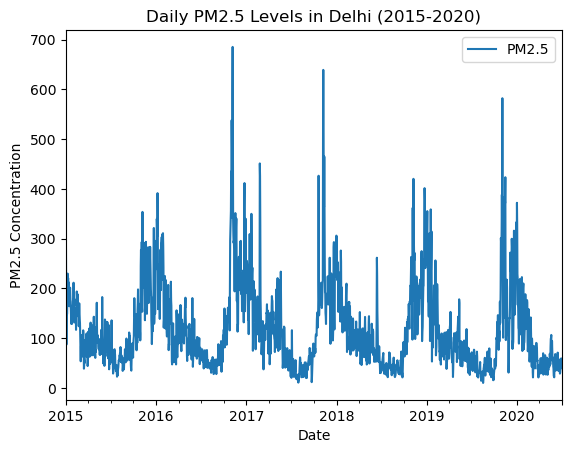

In [21]:
print("\n--- Delhi PM2.5 Time Series ---")
print(delhi_pm25.head())
delhi_pm25.plot(title='Daily PM2.5 Levels in Delhi (2015-2020)')
plt.ylabel('PM2.5 Concentration')
plt.show()

In [11]:

def check_stationarity(series):
    """
    Performs the Augmented Dickey-Fuller test to check for stationarity.
    """
    print("--- Augmented Dickey-Fuller Test Results ---")
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:
        print("\n Result: The series is likely stationary (p-value <= 0.05).")
    else:
        print("\n Result: The series is likely non-stationary (p-value > 0.05).")

check_stationarity(delhi_pm25['PM2.5'])

--- Augmented Dickey-Fuller Test Results ---
ADF Statistic: -3.980268056629862
p-value: 0.0015174318504359628
Critical Values:
	1%: -3.4336386745240652
	5%: -2.8629927557359443
	10%: -2.5675433856598793

 Result: The series is likely stationary (p-value <= 0.05).


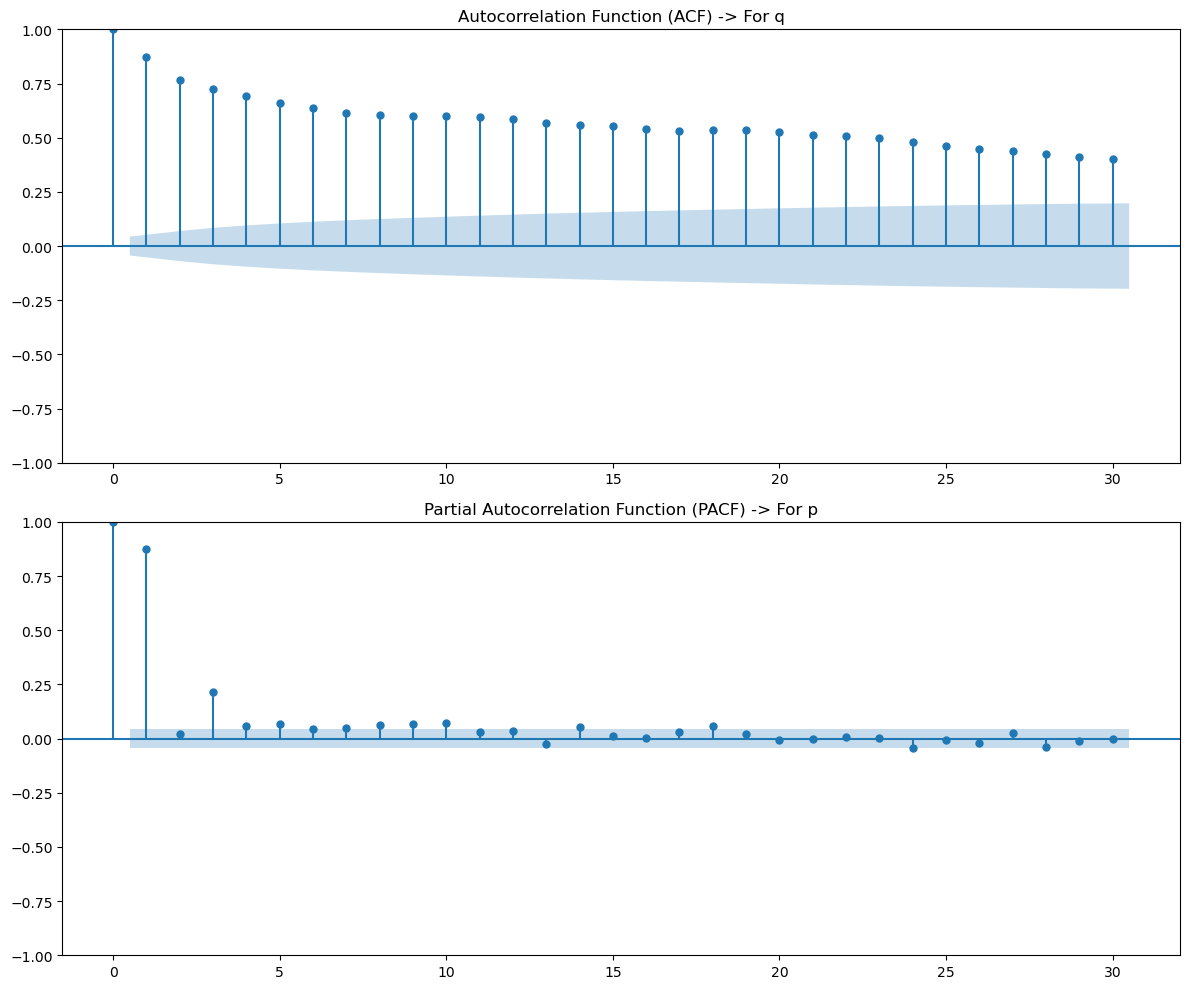

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(delhi_pm25, ax=ax1, lags=30)
ax1.set_title('Autocorrelation Function (ACF) -> For q')
plot_pacf(delhi_pm25, ax=ax2, lags=30)
ax2.set_title('Partial Autocorrelation Function (PACF) -> For p')
plt.tight_layout()
plt.show()

In [24]:
model_arima = ARIMA(delhi_pm25['PM2.5'], order=(2, 1, 2))
results_arima = model_arima.fit()

In [25]:
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 2009
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10201.085
Date:                Thu, 16 Oct 2025   AIC                          20412.169
Time:                        22:00:33   BIC                          20440.194
Sample:                    01-01-2015   HQIC                         20422.457
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2042      0.067      3.041      0.002       0.073       0.336
ar.L2          0.1760      0.059      2.992      0.003       0.061       0.291
ma.L1         -0.3735      0.066     -5.660      0.0

In [26]:
forecast_steps = 180
forecast_arima = results_arima.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=delhi_pm25.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_mean = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()

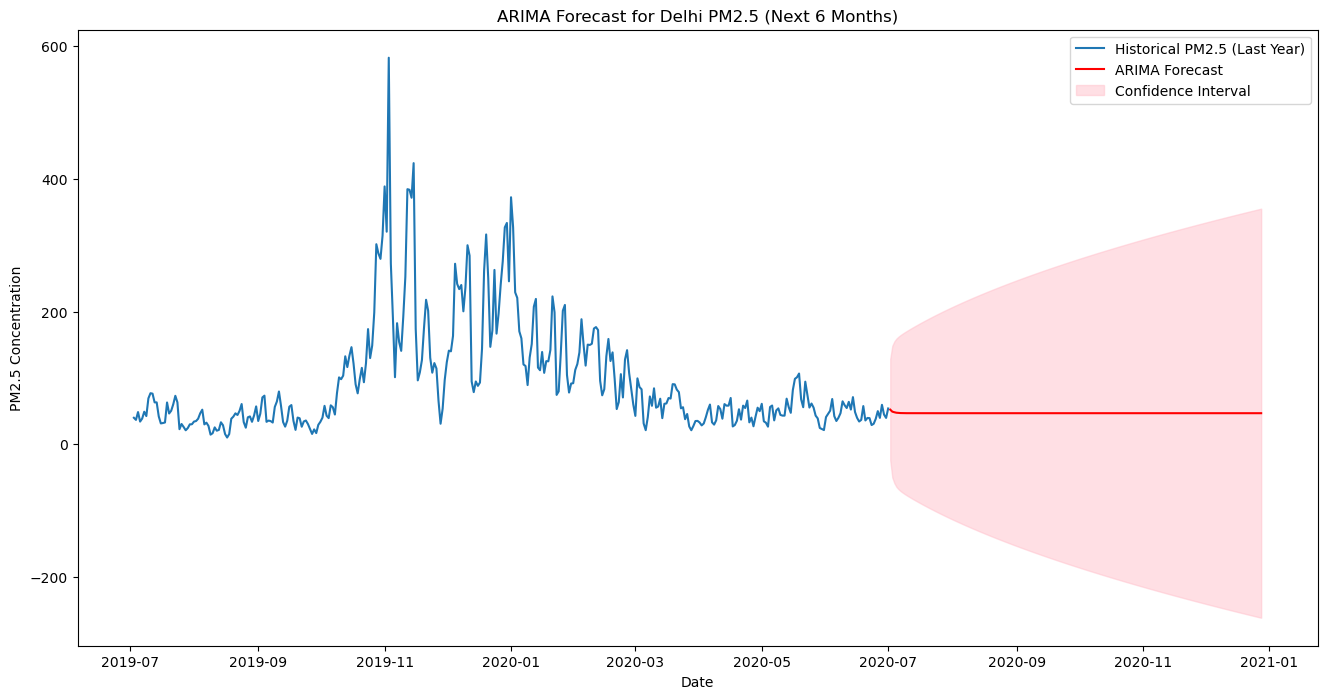

In [27]:
#FORECAST
plt.figure(figsize=(16, 8))
plt.plot(delhi_pm25['PM2.5'][-365:], label='Historical PM2.5 (Last Year)')
plt.plot(forecast_index, forecast_mean, label='ARIMA Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.5, label='Confidence Interval')
plt.title('ARIMA Forecast for Delhi PM2.5 (Next 6 Months)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()

In [28]:
df_prophet = delhi_pm25.reset_index()
df_prophet.rename(columns={'Date': 'ds', 'PM2.5': 'y'}, inplace=True)

In [29]:
print(df_prophet.head())

          ds       y
0 2015-01-01  313.22
1 2015-01-02  186.18
2 2015-01-03   87.18
3 2015-01-04  151.84
4 2015-01-05  146.60


In [30]:
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)

In [31]:
model_prophet.add_country_holidays(country_name='IN')

C:\Users\DELL\anaconda3\Lib\site-packages\holidays\countries\india.py:182: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)


In [32]:
model_prophet.fit(df_prophet)
print(" Prophet model trained successfully.")

22:03:17 - cmdstanpy - INFO - Chain [1] start processing
22:03:18 - cmdstanpy - INFO - Chain [1] done processing


 Prophet model trained successfully.


In [33]:
future = model_prophet.make_future_dataframe(periods=180)

In [34]:
forecast_prophet = model_prophet.predict(future)

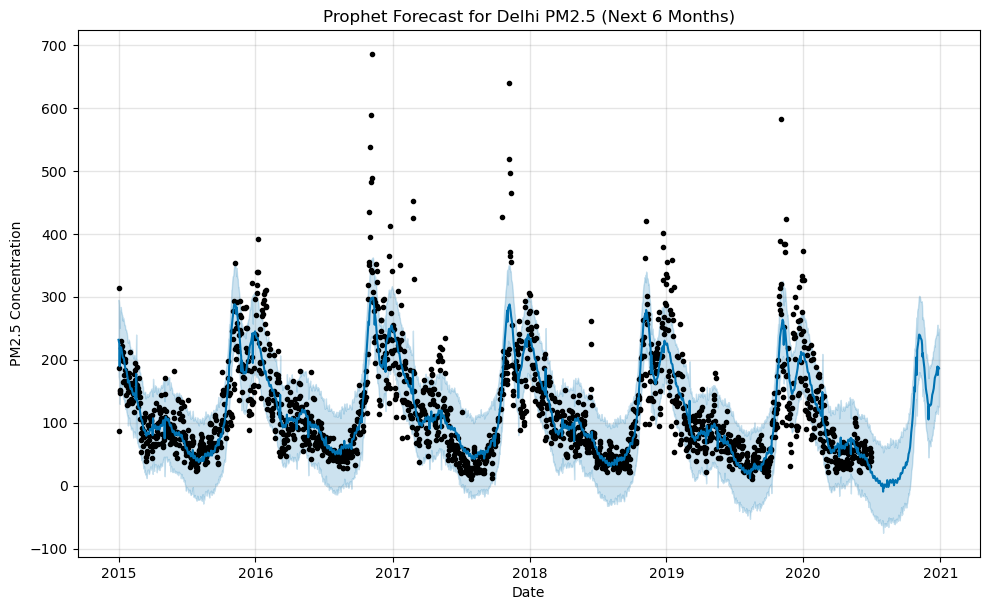

In [35]:
#PROPHET FORCAST
fig1 = model_prophet.plot(forecast_prophet)
plt.title('Prophet Forecast for Delhi PM2.5 (Next 6 Months)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.show()

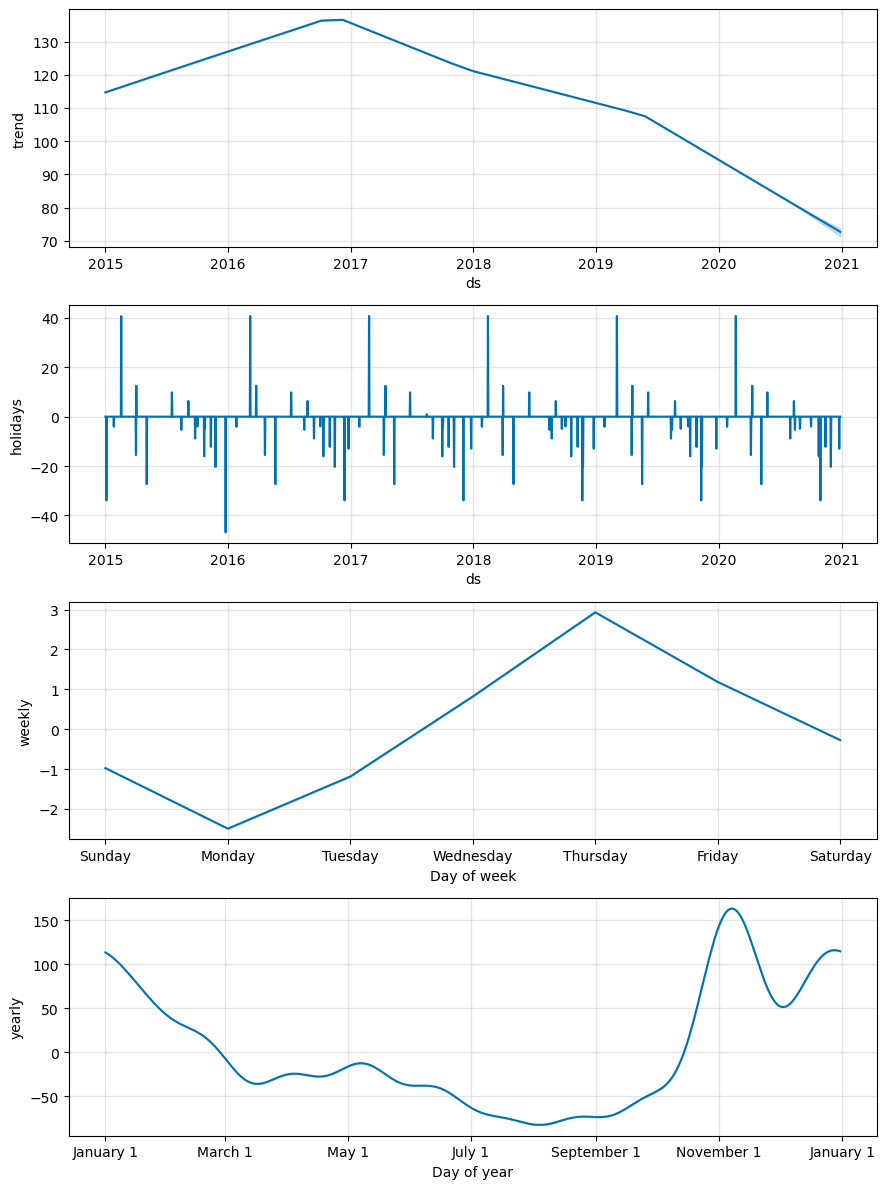

In [36]:
fig2 = model_prophet.plot_components(forecast_prophet)
plt.show()

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [38]:
#CREATE TRAIN AND TEST SETS
train = delhi_pm25[delhi_pm25.index < '2020-01-01']
test = delhi_pm25[delhi_pm25.index >= '2020-01-01']

In [39]:
print(f"Training data points: {len(train)}")
print(f"Test data points: {len(test)}")

Training data points: 1826
Test data points: 183


In [40]:
model_arima_eval = ARIMA(train['PM2.5'], order=(2, 1, 2))
results_arima_eval = model_arima_eval.fit()
forecast_arima = results_arima_eval.forecast(steps=len(test))

In [41]:
#RETRAIN PROPHET

df_prophet_train = train.reset_index().rename(columns={'Date': 'ds', 'PM2.5': 'y'})
model_prophet_eval = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
model_prophet_eval.add_country_holidays(country_name='IN')
model_prophet_eval.fit(df_prophet_train)
future_eval = model_prophet_eval.make_future_dataframe(periods=len(test))
forecast_prophet_eval = model_prophet_eval.predict(future_eval)

forecast_prophet = forecast_prophet_eval.iloc[-len(test):]['yhat']

C:\Users\DELL\anaconda3\Lib\site-packages\holidays\countries\india.py:182: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)
22:18:35 - cmdstanpy - INFO - Chain [1] start processing
22:18:36 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
#CALCULATE PERFORMANCE 
mae_arima = mean_absolute_error(test['PM2.5'], forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test['PM2.5'], forecast_arima))

In [43]:
mae_prophet = mean_absolute_error(test['PM2.5'], forecast_prophet)
rmse_prophet = np.sqrt(mean_squared_error(test['PM2.5'], forecast_prophet))

In [44]:
print("\n--- Model Performance Metrics ---")
print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")


--- Model Performance Metrics ---
ARIMA MAE: 156.71, RMSE: 163.96
Prophet MAE: 33.73, RMSE: 42.82


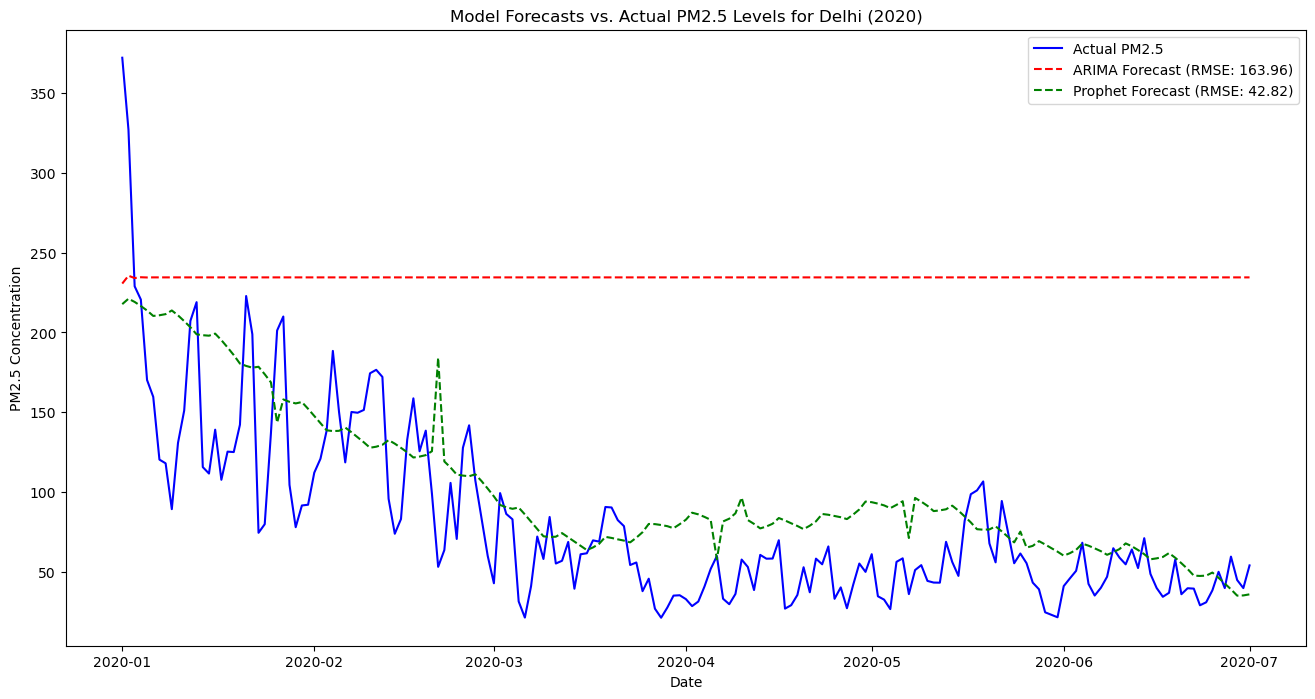

In [45]:
#VISUALIZE FORECAST VS ACTUAL 
plt.figure(figsize=(16, 8))
plt.plot(test.index, test['PM2.5'], label='Actual PM2.5', color='blue')
plt.plot(test.index, forecast_arima, label=f'ARIMA Forecast (RMSE: {rmse_arima:.2f})', color='red', linestyle='--')
plt.plot(test.index, forecast_prophet, label=f'Prophet Forecast (RMSE: {rmse_prophet:.2f})', color='green', linestyle='--')
plt.title('Model Forecasts vs. Actual PM2.5 Levels for Delhi (2020)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()